# Generating images with variational autoencoders

Variational autoencoders are a kind of generative model that's especially appropiate for the task of image editing via concept vectors. They are a modern take on autoencoders - a type of network that aims to encode an input to a low-dimentional latent space and then decode it back -- that mixes ideas from deep learning with Bayesian inference.

![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Autoencoders are not much good at compresion. For this reason, they have fallen out of fashion. VAEs, however, augment autoencoders with a little bit of statistical magic that foreces them to learn continuous, highly structured latent spaces.

How VAEs work:

1. An encoder module turns the input samples `input_img` into two parametres in a latent space of representations `z_mean` and `z_log_variance`
2. You randomly sample a point z from the latent normal distribution that's assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values.
3. A decoder module maps this point in the latent space back to original input image.

Tha parameters if the VAE are trained via two loss functions: a *reconstruction loss* that forces the decoded samples to match the initial inputs, and a *regularization loss* that helps learn well-formed latent spaces and reduce overfitting to the training data.

In [6]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

import numpy as np

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

Encoder implementation

In [3]:
img_input = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(img_input)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=2)(x)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

shape_before_flat = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Decoder implementation

In [7]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flat[1:]), 
                 activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flat[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=2)(x)

x = layers.Conv2DTranspose(1, 3,
                           padding='same',
                           activation='sigmoid')(x)
decoder = Model(decoder_input, x)

z_decoded = decoder(z)

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, you'll set up the loss by writing a custom layer that internally uses the built-in `add_loss` layer method to create an arbitrary loss.

In [10]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_logg = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_logg + kl_loss)
    
    def call(self, inputs):
        x, z_decoded = inputs
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([img_input, z_decoded])

In [12]:
from keras.datasets import mnist

vae = Model(img_input, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [14]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

11493376/11490434 [==============================] - 2s 0us/step
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 204s 3ms/step - loss: 177.4122 - val_loss: 0.1992
Epoch 2/10
10384/60000 [====>.........................] - ETA: 2:48 - loss: 0.1981

KeyboardInterrupt: 

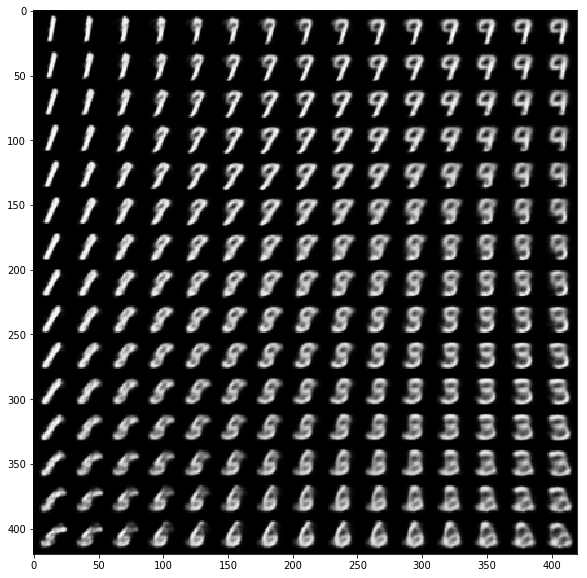

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, ) * 2)
grid_x = norm.ppf(np.linspace(.05, .95, n))
grid_y = norm.ppf(np.linspace(.05, .95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()